# Project for EE301 (Summer 2021) 

Pulkit Gopalani  
Roll No. 180564 


In [ ]:
# Requirements:
# Python >= 3.7
# Numpy 
# Pyaudio
# Matplotlib
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install numpy pyaudio matplotlib ffmpeg-python

In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

In [50]:
def H_z(num, denom):
    '''
    Return rational transfer function given coefficients num and denom for numerator and denominator

    Max degree of num or denom possible is 6, hence please use 0.0 for powers of z not required, and limit length of either array to 7
    '''
    nr = lambda x: num[0]*(x**6) + num[1]*(x**5) + num[2]*(x**4) + num[3]*(x**3) + num[4]*(x**2) + num[5]*(x**1) + num[6]*(x**0)
    dr = lambda x: denom[0]*(x**6) + denom[1]*(x**5) + denom[2]*(x**4) + denom[3]*(x**3) + denom[4]*(x**2) + denom[5]*(x**1) + denom[6]*(x**0)

    return nr/dr

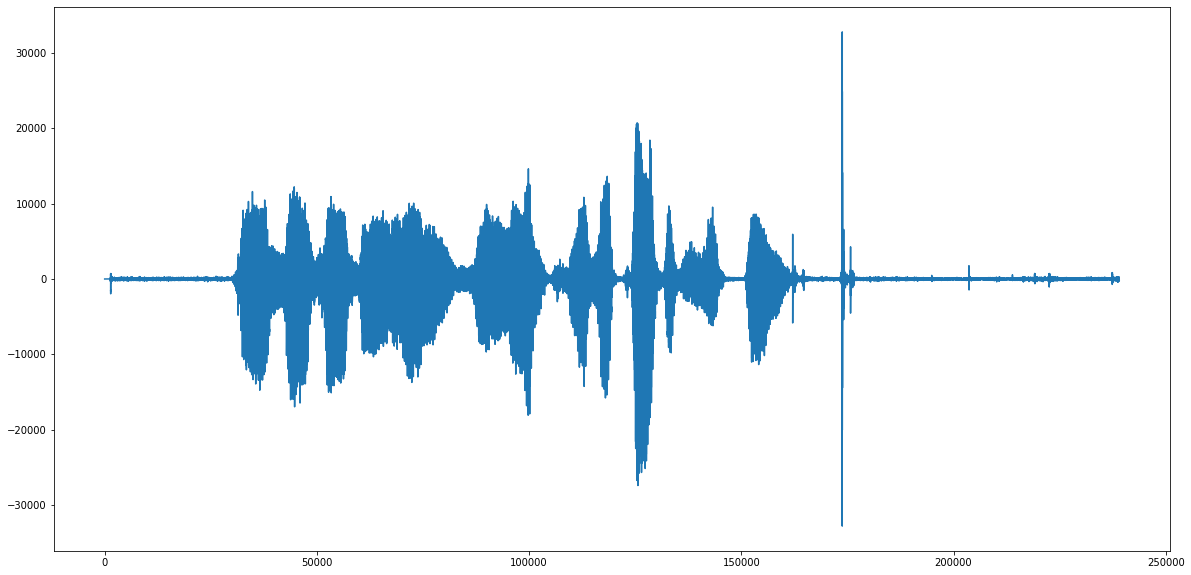

In [ ]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

audio, sr = get_audio()

fft = np.fft.rfft(audio)
freq = np.arange(fft.shape[-1])
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(audio)
# plt.plot(freq, fft.real, freq, fft.imag)
plt.show()

(119521,) (119521,)


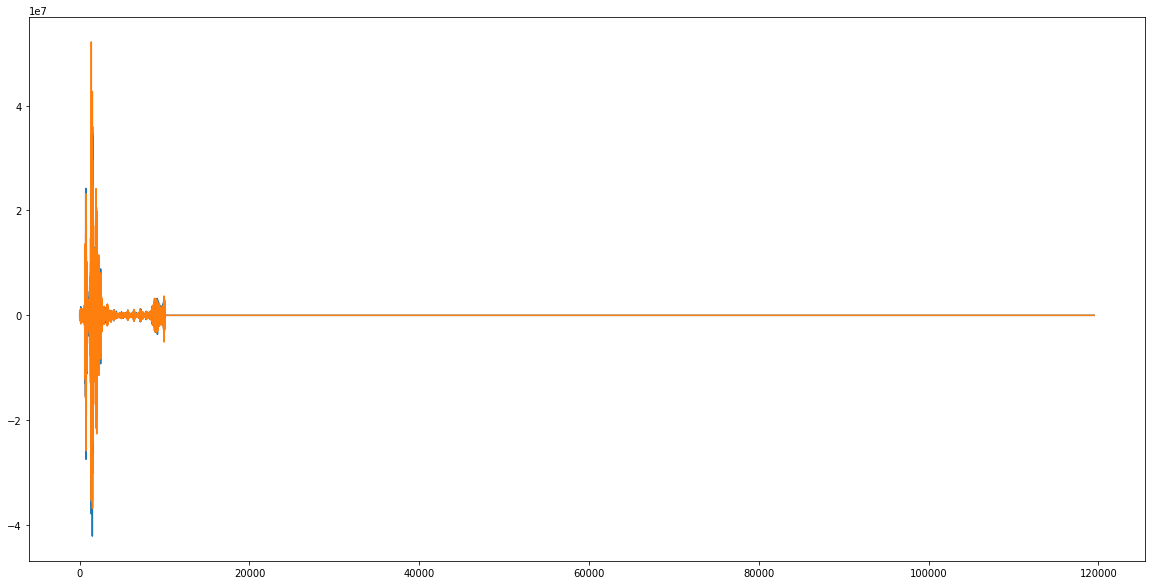

In [ ]:
low_pass = lambda freq: np.concatenate( (np.ones((freq,)), np.zeros((fft.shape[-1]-freq,))))
print(low_pass(30000).shape, fft.shape)
result = low_pass(10000) * fft
plt.figure(figsize=(20,10))
# plt.plot(freq, fft.real, freq, fft.imag, freq, low_pass(30000))
plt.plot(freq, result.real, freq, result.imag)
plt.show()

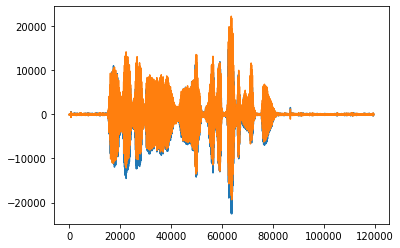

In [ ]:
filtered = np.fft.ifft(result)
plt.plot(freq, filtered.real, freq, filtered.imag)